In [1]:
import itertools
import timeit
from collections.abc import Iterable, Iterator
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

from simplexity.generative_processes.builder import build_generalized_hidden_markov_model, build_hidden_markov_model
from simplexity.generative_processes.generative_process import GenerativeProcess

In [2]:
assert jax.default_backend() == "gpu"
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
repo_dir = Path().absolute().parent
benchmark_data_dir = repo_dir / "data/benchmark_generate"
if not benchmark_data_dir.exists():
    benchmark_data_dir.mkdir(parents=True)
print(benchmark_data_dir)

/workspaces/simplexity/data/benchmark_generate


In [4]:
def generate_observations(
    process: GenerativeProcess,
    initial_state: jax.Array,
    sequence_len: int,
    batch_size: int,
    num_batches: int,
) -> Iterator[jax.Array]:
    """Yields batches of observations generated from a generative process."""
    key = jax.random.PRNGKey(0)
    states = jnp.repeat(initial_state[None, :], batch_size, axis=0)
    for _ in range(num_batches):
        key, batch_key = jax.random.split(key)
        batch_keys = jax.random.split(batch_key, batch_size)
        states, batch_observations = process.generate(states, batch_keys, sequence_len)
        yield batch_observations

In [5]:
def test_generate_shape(
    process: GenerativeProcess,
    initial_state: jax.Array,
    sequence_len: int = 3,
    batch_size: int = 2,
    num_batches: int = 4,
) -> None:
    """Simple test of the generate function."""
    observations = jnp.stack(list(generate_observations(process, initial_state, sequence_len, batch_size, num_batches)))
    assert observations.shape == (num_batches, batch_size, sequence_len)

In [6]:
def time_generate(
    process: GenerativeProcess,
    initial_state: jax.Array,
    sequence_len: int,
    batch_size: int,
    num_batches: int,
    num_runs: int = 1,
) -> float:
    """Get the average time it takes to generate a batch of observations."""

    def run_generate():
        for _ in generate_observations(process, initial_state, sequence_len, batch_size, num_batches):
            pass

    return timeit.timeit(run_generate, number=num_runs) / (num_batches * num_runs)

In [7]:
def get_benchmark_results(
    process: GenerativeProcess,
    initial_state: jax.Array,
    num_batches: int,
    log2_sequence_lengths: Iterable[int] = range(2, 12),
    log2_batch_sizes: Iterable[int] = range(5),
) -> pd.DataFrame:
    """Get benchmark results for different combinations of sequence lengths and batch sizes."""
    data = []
    for log2_sequence_len, log2_batch_size in itertools.product(log2_sequence_lengths, log2_batch_sizes):
        sequence_len = 2**log2_sequence_len
        batch_size = 2**log2_batch_size
        time = time_generate(process, initial_state, sequence_len, batch_size, num_batches)
        data.append({"sequence_len": sequence_len, "batch_size": batch_size, "time_per_batch": time})

    return pd.DataFrame.from_records(data)

In [8]:
def plot_benchmark_results(df: pd.DataFrame, model_name: str, num_batches: int) -> None:
    """Plot benchmark results."""
    sequence_lengths = sorted(df["sequence_len"].unique().tolist())
    _, ax = plt.subplots()
    for batch_size, group in df.groupby("batch_size"):
        ax.semilogx(group["sequence_len"], group["time_per_batch"], label=f"batch_size={batch_size}", marker="o")
    ax.legend()
    ax.minorticks_off()
    ax.set_xticks(sequence_lengths)
    ax.set_xticklabels(sequence_lengths)
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Time per batch (s)")
    ax.set_title(f"{model_name}, ({num_batches=})")
    plt.show()

In [9]:
def benchmark(
    model: GenerativeProcess,
    initial_state: jax.Array,
    model_name: str,
    num_batches: int = 16,
    results_dir: Path = benchmark_data_dir,
) -> None:
    """Run a series of benchmark trials for the generative function, plot and save the results."""
    test_generate_shape(model, initial_state)
    path = results_dir / f"{model_name}_generate_benchmark.csv"
    if path.exists():
        df = pd.read_csv(path)
    else:
        df = get_benchmark_results(model, initial_state, num_batches)
        df.to_csv(path, index=False)
    plot_benchmark_results(df, model_name, num_batches)

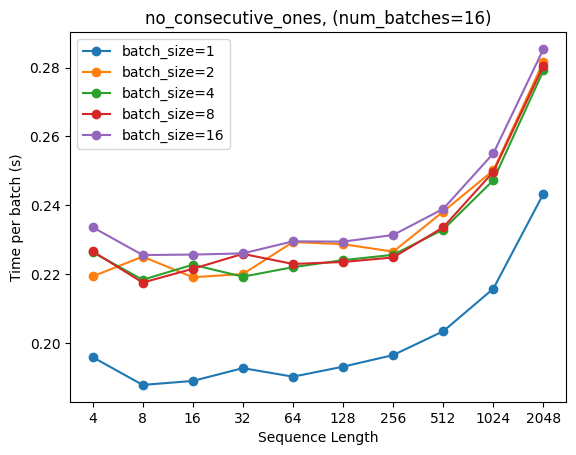

In [10]:
model_name = "no_consecutive_ones"
hmm = build_hidden_markov_model(model_name, p=0.5)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

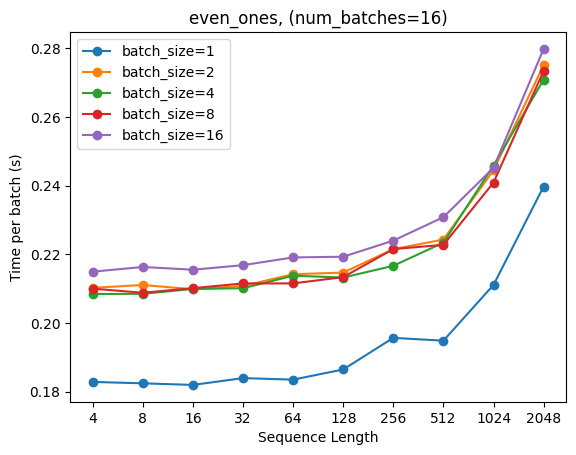

In [11]:
model_name = "even_ones"
hmm = build_hidden_markov_model(model_name, p=0.5)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

In [12]:
model_name = "zero_one_random"
hmm = build_hidden_markov_model(model_name, p=0.5)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

ValueError: 'z1r' is not a valid HMMProcessType

In [ ]:
model_name = "post_quantum"
ghmm = build_generalized_hidden_markov_model(model_name, log_alpha=1, beta=0.5)
initial_state = ghmm.state_eigenvector
benchmark(ghmm, initial_state, model_name)

In [ ]:
model_name = "days_of_week"
hmm = build_hidden_markov_model(model_name)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

In [ ]:
model_name = "tom_quantum"
ghmm = build_generalized_hidden_markov_model(model_name, log_alpha=1.0, beta=1.0)
initial_state = ghmm.state_eigenvector
benchmark(ghmm, initial_state, model_name)

In [ ]:
model_name = "fanizza"
ghmm = build_generalized_hidden_markov_model(model_name, log_alpha=2000, beta=0.49)
initial_state = ghmm.state_eigenvector
benchmark(ghmm, initial_state, model_name)

In [ ]:
model_name = "rrxor"
hmm = build_hidden_markov_model(model_name, pR1=0.5, pR2=0.5)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

In [ ]:
model_name = "mess3"
hmm = build_hidden_markov_model(model_name, x=0.15, a=0.6)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)